# COVID Mitigation Measures => Social Distancing
## Objective
According to the World Health Organization and the CDC, social distancing is currently the most effective way to slow the spread of COVID-19. 
- analyze the containment measures mandated around the world intended to reduce the transmission of COVID-19
- provide insights on what has changed in response to the measures  aimed at combating COVID-19 
)

## Methodology

### Dataset used: 

**Global Coronavirus (COVID-19) Data (Johns Hopkins)** [link](https://data.world/covid-19-data-resource-hub/covid-19-case-counts)
- Date <br>
- Province/State   <br>
- Country/Region   <br>
- Confirmed   <br>
- Deaths  <br>
- Recovered <br>

**Google Mobility Reports** [link] (https://www.google.com/covid19/mobility/)
- Country/Region <br>
- Sub Region <br>
- Date <br>
- Retail And Recreation <br>
- Grocery And Pharmacy <br>
- Parks <br>
- Transit Stations <br>
- Workplace <br>
- Residential <br>


**Covid Containment Dataset** [link](http://epidemicforecasting.org/containment)
- Country (and state for the US) <br>
- Textual description of the measure  <br>
- Start date of measure  <br>
- End date (if available)  <br>
- URL to source of more information  <br>
- Systematic keyword labels (e.g. "travel ban" or "hygiene enforcement")  <br>



In [3]:
import findspark, random, tweepy, plotly
import pandas as pd
from simple_tokenize import *
from wordcloud import WordCloud, STOPWORDS
import chart_studio.plotly as py
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import numpy as np
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from os import path
import os
spark = SparkSession.builder.appName("YourTest").master("local[2]").config('spark.ui.port', random.randrange(4000,5000)).getOrCreate()

In [4]:
mobility = spark.read.csv("./Global_Mobility_Report2.csv",sep=',',header=True)
mobility = mobility.toDF('Country_Region_Code','Country_Region','Sub_Region_1','Sub_Region_2','Date',\
                         'Retail_And_Recreation','Grocery_And_Pharmacy',\
                         'Parks','Transit_Stations','Workplace',\
                         'Residential').cache()
cases = spark.read.csv("../covid-19/data/time-series-19-covid-combined.csv", sep=",", header=True)
cases = cases.toDF('Date','Country_Region','Sub_Region1','Lat','Long','Confirmed','Recovered','Deaths').cache()
canada_mobility = spark.read.csv("./", sep=',',header=True)
mitigation = spark.read.csv("./countermeasures_db_johnshopkins.csv", sep = ",", header=True).drop('_c0')
# mitigation_df = pd.read_csv("./countermeasures_db_johnshopkins.csv",index_col=0)
mitigation_raw = spark.read.csv("./COVID 19 Containment measures data.csv", sep=',',header=True)


## Data Cleaning and some basic stats

In [5]:
cases=cases.withColumn("Country_Region", regexp_replace("Country_Region", 'US', 'United States'))
cases=cases.withColumn("Country_Region", regexp_replace("Country_Region", 'Taiwan*', 'Taiwan'))
cases=cases.withColumn("Country_Region", regexp_replace("Country_Region", 'Cape Verde', 'Cabo Verde'))
mobility=mobility.withColumn("Country_Region", regexp_replace("Country_Region",'Myanmar (Burma)', 'Burma'))
mobility=mobility.withColumn("Country_Region", regexp_replace("Country_Region","Côte d'Ivoire", "Cote d'Ivoire"))
# mobility.show(2, False)
# cases.show(2, False)
mobility.createOrReplaceTempView("mobility")
cases.createOrReplaceTempView("cases")
mitigation.createOrReplaceTempView("mitigation")

In [6]:
mobi_countries_count = spark.sql("SELECT DISTINCT(Country_Region) from mobility").count()
cases_countries_count = spark.sql("SELECT DISTINCT(Country_Region) from cases").count()
print("No. Countries w/ Mobility Data: "+str(mobi_countries_count)+ "\nNo. Countries w/ Case Data: "+str(cases_countries_count))
no_match_count = spark.sql("SELECT DISTINCT(cases.Country_Region) from cases\
                      left join mobility on cases.Country_Region = mobility.Country_Region\
                      where mobility.Country_Region IS NULL").count()
print("No. countries without mobility: "+ str(no_match_count) + " vs. above " +\
     str(cases_countries_count-mobi_countries_count))

No. Countries w/ Mobility Data: 131
No. Countries w/ Case Data: 185
No. countries without mobility: 63 vs. above 54


In [7]:
def find_countries_most_cases():
    top_countries = spark.sql("SELECT Country_Region, \
     SUM(Confirmed) AS Total_Cases,\
     SUM(Confirmed)-SUM(Recovered)-SUM(Deaths) AS Unresolved_Cases,\
     SUM(Recovered) AS Recovered_Cases,\
     SUM(Deaths) AS Total_Deaths\
     FROM cases\
     group by Country_Region \
     order by sum(Confirmed) DESC")
    top_countries.show()

In [8]:
find_countries_most_cases()

+--------------+-----------+----------------+---------------+------------+
|Country_Region|Total_Cases|Unresolved_Cases|Recovered_Cases|Total_Deaths|
+--------------+-----------+----------------+---------------+------------+
| United States|1.0383461E7|       9332659.0|       654227.0|    396575.0|
|         China|  5764038.0|       1691698.0|      3859257.0|    213083.0|
|         Italy|  4001135.0|       2800483.0|       728330.0|    472322.0|
|         Spain|  3690554.0|       2217633.0|      1120967.0|    351954.0|
|       Germany|  2820050.0|       1702025.0|      1062771.0|     55254.0|
|        France|  2358650.0|       1583301.0|       514484.0|    260865.0|
|          Iran|  1801716.0|        827667.0|       860335.0|    113714.0|
|United Kingdom|  1568938.0|       1380345.0|         8830.0|    179763.0|
|        Turkey|   982426.0|        889339.0|        72043.0|     21044.0|
|   Switzerland|   606171.0|        368333.0|       216783.0|     21055.0|
|       Belgium|   590872

In [9]:
def find_canada_provinces():
    canada_cases = spark.sql("SELECT Date,Sub_Region1, \
     SUM(Confirmed) AS Confirmed_Cases,\
     SUM(Recovered) AS Recovered_Cases,\
     SUM(Deaths) AS Total_Deaths\
     FROM cases\
     WHERE Country_Region = 'Canada'\
     group by Date,Sub_Region1 \
     order by sum(Confirmed) DESC")
    canada_cases.show()

In [10]:
canada_mobility = mobility.filter("country_region == 'Canada'").filter("Sub_Region_1 != 'null'")\
                    .drop('Country_Region_code','Country_Region','Sub_Region_2')
canada_mobility.createOrReplaceTempView("canada_mobility")
canada_mobility_by_province_by_date = \
    spark.sql("SELECT Sub_Region_1, Date, \
                SUM(Retail_And_Recreation) as Retail_and_Recreation, \
                SUM(Grocery_And_Pharmacy) AS Grocery_and_Pharmacy, \
                SUM(Parks) AS Parks, \
                SUM(Transit_Stations) AS Transit_Stations , \
                SUM(Workplace) AS Workplace, \
                SUM(Residential) AS Residential \
                FROM canada_mobility\
                group by Date,Sub_Region_1 order by Date")
canada_mobility_by_province_by_date.show()

+--------------------+----------+---------------------+--------------------+-----+----------------+---------+-----------+
|        Sub_Region_1|      Date|Retail_and_Recreation|Grocery_and_Pharmacy|Parks|Transit_Stations|Workplace|Residential|
+--------------------+----------+---------------------+--------------------+-----+----------------+---------+-----------+
|Newfoundland and ...|2020-02-15|                 -1.0|                -2.0|-16.0|            -1.0|     -1.0|        1.0|
|             Alberta|2020-02-15|                  7.0|                 3.0| 24.0|             7.0|     -2.0|       -1.0|
|              Quebec|2020-02-15|                  4.0|                 0.0| 20.0|             5.0|      2.0|        1.0|
|       New Brunswick|2020-02-15|                 -3.0|                -7.0|-13.0|            11.0|     -3.0|        1.0|
|         Nova Scotia|2020-02-15|                 -1.0|                -6.0|-10.0|             4.0|     -1.0|        0.0|
|               Yukon|20

# Containment Measures Analysis
## What mitigation measures are most popular? 

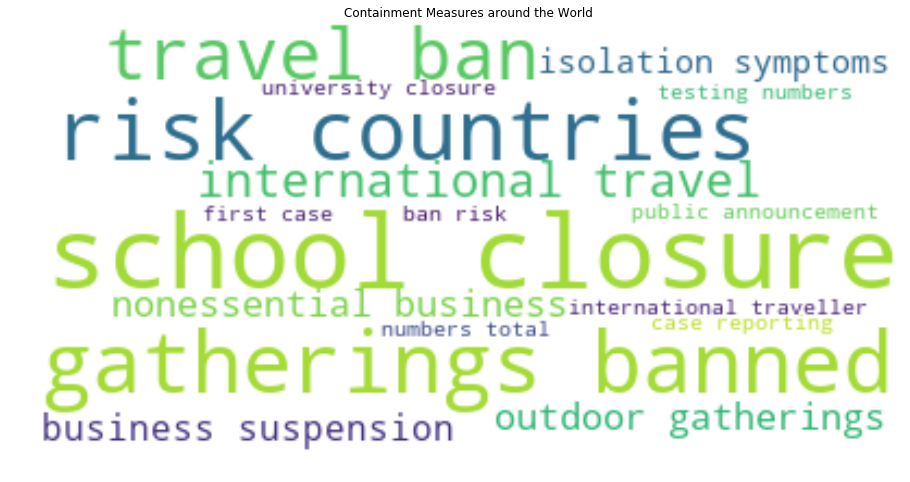

In [11]:
# CREATE WORD CLOUD
text = mitigation_raw.select('keywords').rdd.flatMap(lambda x:x).collect()
text = ' '.join(filter(None,text))
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_words=500,background_color="white",min_font_size=10,max_font_size=100,stopwords=stopwords).generate(text)
plt.figure(figsize=[18,8])
plt.title('Containment Measures around the World')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");
plt.show()
wordcloud.generate(text)

# store to file
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
wordcloud.to_file(path.join(d, "containment_measures.png"))

From the word cloud it seems like school closure is one of the most prominent mitigation measures. Now let's see when countries decided to shut them down.

# When did schools start to close around the world

In [ ]:
school_closures = spark.sql("SELECT Country as `Number of Countries`,Min(Date) as `School Closure Date` from mitigation \
                            where `School closure`> 0 group by Country")
school_closures = school_closures.groupBy('School Closure Date').count().orderBy('School Closure Date')
school_closures.show()
# school_closures.groupBy().sum().show()

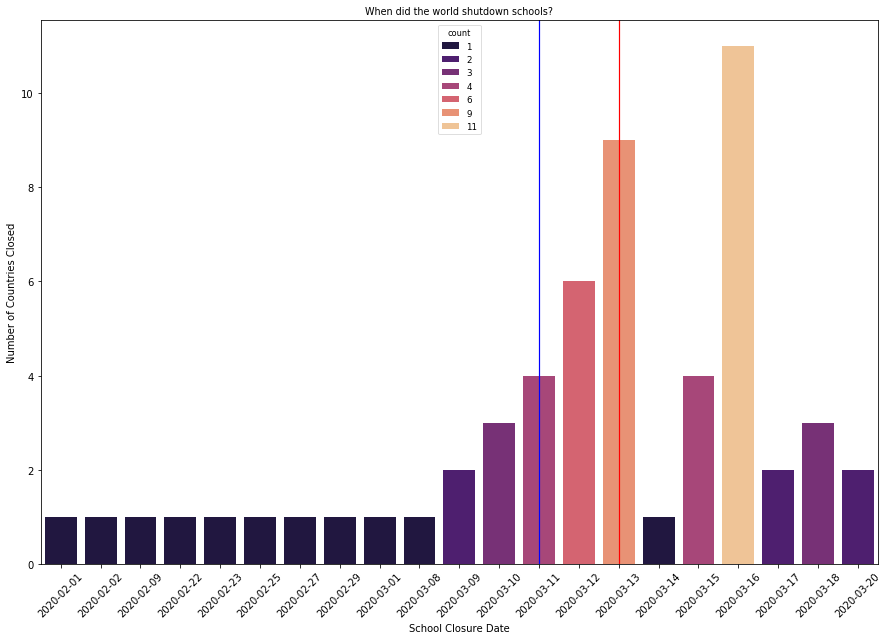

In [13]:
x=school_closures.toPandas() 
# x.groupby([x["School Closure Date"]]).count().plot(kind="bar")
plt.subplots(figsize = (15,10))
cmap = sns.cm.rocket_r
sns.set_context('paper')
# create plot
g = sns.barplot(x = 'School Closure Date',y='count', hue = 'count', data = x, palette = 'magma', dodge=False)
plt.title('When did the world shutdown schools?')
g.set_xticklabels(g.get_xticklabels(),rotation=45)
plt.xlabel("School Closure Date")
plt.ylabel("Number of Countries Closed")
plt.axvline(14, 0,4, color='r', label = "End of Mission")
plt.axvline(12, 0,4, color='b', label = "Declaration of Pandemic")
plt.savefig("School_Closure.png")
plt.show(g)

The blue line indicates when the World Health Organization declared COVID-19 as a pandemic. A day after the University of Waterloo sent out an announcement saying they couldn't cancel in person lectures because they are vital to our #AcademicMission. Finally the red line indicates when the University of Waterloo changed their mind and shutdown the school.  The plot shows that most countries held off from shutting down school until 5 days after the pandemic was declared. 

In [14]:
mitigation.createOrReplaceTempView("mitigation")
# mitigation.show(1, False)
first_date = spark.sql("SELECT Country,min(Date) as First_Case_Date FROM mitigation\
                       WHERE `Confirmed Cases` > 1 GROUP BY Country ORDER BY MIN(Date)")
# first_date.describe().show()
first_closure = spark.sql("SELECT Country as Country1, MIN(Date) as First_Closure_Date FROM mitigation \
                          WHERE `School closure`> 0 OR \
                          `Activity cancellation`> 0 OR \
                          `Nonessential business suspension`> 0\
                          GROUP BY Country")
# first_closure.describe().show()
cases_now = spark.sql("SELECT Country_Region as Country2,`Confirmed`  from cases\
                        where (Country_Region, Date) in (\
                            Select Country_Region, MAX(Date) as Date from cases group by Country_Region)")

cases_now = cases_now.groupBy("Country2").agg({'Confirmed':'sum'}).withColumnRenamed("SUM(Confirmed)", "Confirmed").orderBy('Confirmed',ascending=False)
cases_now.show()

first = first_date.join(first_closure,first_date.Country==first_closure.Country1,how='left').drop('Country1').filter("First_Closure_Date != 'null'")
first = first.join(cases_now, first.Country == cases_now.Country2, how = 'left').drop('Country2')
# first.show()
first=first.toPandas()
first.head()


+--------------+---------+
|      Country2|Confirmed|
+--------------+---------+
| United States| 759086.0|
|         Spain| 198674.0|
|         Italy| 178972.0|
|        France| 154097.0|
|       Germany| 145184.0|
|United Kingdom| 121172.0|
|        Turkey|  86306.0|
|         China|  83805.0|
|          Iran|  82211.0|
|        Russia|  42853.0|
|        Brazil|  38654.0|
|       Belgium|  38496.0|
|        Canada|  35632.0|
|   Netherlands|  32838.0|
|   Switzerland|  27740.0|
|      Portugal|  20206.0|
|         India|  17615.0|
|          Peru|  15628.0|
|       Ireland|  15251.0|
|       Austria|  14749.0|
+--------------+---------+
only showing top 20 rows



,Country,First_Case_Date,First_Closure_Date,Confirmed
0,China,2020-01-23,2020-02-01,83805.0
1,Hong Kong,2020-01-23,2020-02-07,NaN
2,Japan,2020-01-23,2020-03-24,10797.0
3,Singapore,2020-01-24,2020-02-07,6588.0
4,France,2020-01-24,2020-02-29,154097.0


In [15]:
first['First_Closure_Date'] = pd.to_datetime(first['First_Closure_Date'])
first['First_Case_Date'] = pd.to_datetime(first['First_Case_Date'])
first['delay'] = (first['First_Closure_Date'] - first['First_Case_Date']).dt.days
# first.head()

In [16]:
cases.show()

+----------+--------------+-----------+----+----+---------+---------+------+
|      Date|Country_Region|Sub_Region1| Lat|Long|Confirmed|Recovered|Deaths|
+----------+--------------+-----------+----+----+---------+---------+------+
|2020-01-22|   Afghanistan|       null|33.0|65.0|        0|        0|     0|
|2020-01-23|   Afghanistan|       null|33.0|65.0|        0|        0|     0|
|2020-01-24|   Afghanistan|       null|33.0|65.0|        0|        0|     0|
|2020-01-25|   Afghanistan|       null|33.0|65.0|        0|        0|     0|
|2020-01-26|   Afghanistan|       null|33.0|65.0|        0|        0|     0|
|2020-01-27|   Afghanistan|       null|33.0|65.0|        0|        0|     0|
|2020-01-28|   Afghanistan|       null|33.0|65.0|        0|        0|     0|
|2020-01-29|   Afghanistan|       null|33.0|65.0|        0|        0|     0|
|2020-01-30|   Afghanistan|       null|33.0|65.0|        0|        0|     0|
|2020-01-31|   Afghanistan|       null|33.0|65.0|        0|        0|     0|

In [17]:
mit = mitigation_raw.select('Date Start', 'Description of measure implemented', 'Keywords').filter("Country = 'Canada'")\
.orderBy('Date Start').toPandas()
#.show(10, False)
# mit = mitigation.filter("Country = 'Canada'").toPandas()
pd.set_option('display.max_colwidth', -1)
mit

,Date Start,Description of measure implemented,Keywords
0,None,Canada advises travellers entering Canada to self-isolate for 14 days.,international traveller quarantine - risk countries
1,"Mar 12, 2020","Masks should be used by a symptomatic individual, if available, to provide a physical barrier that may help to prevent the transmission of the virus by blocking the dispersion of large particle respiratory droplets propelled by coughing, sneezing and talking. A face mask should always be combined with other measures such as respiratory etiquette and hand hygiene","handwashing encouragement, public mask encouragement"
2,"Mar 12, 2020","""Voluntary home quarantine (""""self-isolation"""") is recommended for an asymptomatic person","should they develop COVID-19)."""
3,"Mar 12, 2020","Isolation is recommended for a symptomatic individual that is suspected of having, or known to have, COVID-19. They are directed by PHA to isolate themselves in the home-setting and avoid contact with others until PHA has advised that they are no longer considered contagious",contact isolation - symptoms
4,"Mar 12, 2020","Refers to hand washing with soap and water or hand sanitizing with alcoholic solutions, gels or tissues to maintain clean hands and fingernails. It should be performed frequently with soap and water for at least 15-20 seconds:",None
5,"Mar 18, 2020","Canada announces financial help, through the COVID-19 Economic Response Plan, for Canadians and businesses facing hardship as a result of the COVID-19 outbreak.","economic incentives, financial incentive"
6,"Mar 19, 2020","The NML tests seem to be used to confirm results found at the provincial level. So in terms of people tested, there is double counting here with the provincial figures. These figures are presented as if total tests were the sum of positive and negative tests. However the figures indicated in the source do not some to the total (628 positive plus 42,157 negative).",testing numbers total


In [18]:
df= pd.read_csv("./covid_19_data.csv",index_col=0)
df.rename(columns={'ObservationDate':'Date'}, inplace=True)
# last_date = str(df.Date.max().date())
df.head()
df2 = df.groupby(['Country/Region','Date'])['Confirmed'].sum().diff()
df2 = df2.reset_index()
df2.loc[df2.Confirmed<0,'Confirmed'] =0 
first['new_cases'] = df2['Confirmed']
first.head()
first

,Country,First_Case_Date,First_Closure_Date,Confirmed,delay,new_cases
0,China,2020-01-23,2020-02-01,83805.0,9,NaN
1,Hong Kong,2020-01-23,2020-02-07,NaN,15,1.0
2,Japan,2020-01-23,2020-03-24,10797.0,61,0.0
3,Singapore,2020-01-24,2020-02-07,6588.0,14,0.0
4,France,2020-01-24,2020-02-29,154097.0,36,0.0
5,Taiwan,2020-01-24,2020-02-02,NaN,9,0.0
6,South Korea,2020-01-24,2020-02-26,NaN,33,0.0
7,Germany,2020-01-28,2020-02-28,145184.0,31,0.0
8,Russia,2020-01-31,2020-03-16,42853.0,45,0.0
9,Italy,2020-01-31,2020-02-22,178972.0,22,0.0


In [21]:
x = np.log10(first.Confirmed)
y = np.log10(first.new_cases)
z = first.delay
plt.figure(figsize=(15,8))
xticks = [1,3,10,30,100,300,1000,3000,10000,30000,100000,300000,500000]
plt.xticks(np.log10(xticks),xticks)
yticks =  [1,3,10,30,100,300,1000,3000,10000,30000]
plt.yticks(np.log10(yticks),yticks)
ax = sns.scatterplot(x,y,hue=z,palette='RdBu_r');
# plt.title('Effect of delay on country performance ({})'.format(last_date));

/home/cgkdever/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in log10



Many countries were able to reduce the impact of the virus not only by taking suitable measure but also by being able to enforce them quickly after discovering the first case.
Now let's look at the world's response to the mitigation measures imposed by analyzing community mobility.

# Community Mobility analysis

In [22]:
canada_mobility = mobility.filter("country_region == 'Canada'").filter("Sub_Region_1 != 'null'")\
                    .drop('Country_Region_code','Country_Region','Sub_Region_2')
canada_mobility.createOrReplaceTempView("canada_mobility")
canada_mobility_by_province_by_date = \
    spark.sql("SELECT Sub_Region_1 as Province, Date, \
                SUM(Retail_And_Recreation) as Retail_and_Recreation, \
                SUM(Grocery_And_Pharmacy) AS Grocery_and_Pharmacy, \
                MEAN(Parks) AS Parks, \
                SUM(Transit_Stations) AS Transit_Stations , \
                SUM(Workplace) AS Workplace, \
                SUM(Residential) AS Residential \
                FROM canada_mobility\
                group by Date,Sub_Region_1 order by Date")
canada_mobility_df= canada_mobility_by_province_by_date.toPandas()
# canada_mobility_by_province_by_date
# ontario_mobility = canada_mobility_by_province_by_date.filter("Province='Ontario'").orderBy('Date','Prov').drop('Province').toPandas()
# ontario_mobility['Date'].dropna()

# ontario_mobility['Date'] = pd.to_datetime(ontario_mobility['Date'])
# sns.heatmap(ontario_mobility, annot=True)
# canada_mobility_canada_mobility['Date'].dropna()
# canada_mobility_canada_mobility['Date'] = pd.to_datetime(canada_mobility_canada_mobility['Date'], format='%m%d%Y')
print(canada_mobility_df.columns.tolist())
a = ['Yukon', 'Northwest Territories', 'Nunavut','Prince Edward Island']
canada_mobility_df = canada_mobility_df[~canada_mobility_df["Province"].isin(a)]


['Province', 'Date', 'Retail_and_Recreation', 'Grocery_and_Pharmacy', 'Parks', 'Transit_Stations', 'Workplace', 'Residential']


In [ ]:
canada_mobility_res= canada_mobility_df.pivot("Province", "Date", "Residential")
# canada_mobility_res= canada_mobility_res.sort_index(level=0, ascending=True, inplace=True)
plt.subplots(figsize=(12, 2))
# ax = sns.heatmap(canada_mobility_res)
# ax.set_aspect("equal")
g = sns.heatmap(canada_mobility_res,cmap='RdBu',square=True)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
ax.set_xlabel('')
g.invert_yaxis()
g.xaxis.set_ticks_position("top")
fig = plt.gcf()  # or by other means, like plt.subplots
figsize = fig.get_size_inches()
fig.set_size_inches(figsize * 1.5)
plt.ylabel("Residential", fontsize=12)
fig = g.get_figure()
fig.savefig("Residential.png")
plt.show(g)


In [ ]:
plt.subplots(figsize=(12, 2))
canada_mobility_parks= canada_mobility_df.pivot("Province", "Date", "Parks")
g =sns.heatmap(canada_mobility_parks,cmap='RdBu',square=True, vmin=-50, vmax=50)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.axes.get_xaxis().set_visible(False)
fig = plt.gcf()  # or by other means, like plt.subplots
figsize = fig.get_size_inches()
fig.set_size_inches(figsize * 1.5)
plt.ylabel("Parks", fontsize=12)
fig = g.get_figure()
fig.savefig("Parks.png")
plt.show(g)
# plt.show(g)

In [ ]:
plt.subplots(figsize=(12, 2))
canada_mobility_grocery= canada_mobility_df.pivot("Province", "Date", "Grocery_and_Pharmacy")
g =sns.heatmap(canada_mobility_grocery,cmap='RdBu',square=True)
g.set_xticklabels(g.get_xticklabels(),rotation=45)

g.axes.get_xaxis().set_visible(False)
fig = plt.gcf()  # or by other means, like plt.subplots
figsize = fig.get_size_inches()
fig.set_size_inches(figsize * 1.5)
plt.ylabel("Grocery and Pharmacy", fontsize=12)
fig = g.get_figure()
fig.savefig("grocery.png")
plt.show(g)

In [ ]:
plt.subplots(figsize=(12, 2))
canada_mobility_transit= canada_mobility_df.pivot("Province", "Date", "Workplace")
g =sns.heatmap(canada_mobility_transit,cmap='RdBu',square=True)
g.set_xticklabels(g.get_xticklabels(),rotation=45)

g.axes.get_xaxis().set_visible(False)
fig = plt.gcf()  # or by other means, like plt.subplots
figsize = fig.get_size_inches()
fig.set_size_inches(figsize * 1.5)
plt.ylabel("Workplace", fontsize=12)
fig = g.get_figure()
fig.savefig("Workplace.png")
plt.show(g)

In [ ]:
plt.subplots(figsize=(12, 2))
canada_mobility_transit= canada_mobility_df.pivot("Province", "Date", "Transit_Stations")
g =sns.heatmap(canada_mobility_transit,cmap='RdBu',square=True)
g.set_xticklabels(g.get_xticklabels(),rotation=45)

g.axes.get_xaxis().set_visible(False)
fig = plt.gcf()  # or by other means, like plt.subplots
figsize = fig.get_size_inches()
fig.set_size_inches(figsize * 1.5)
plt.ylabel("Transit", fontsize=12)
fig = g.get_figure()
fig.savefig("Transit.png")
plt.show(g)

In [ ]:
plt.subplots(figsize=(12, 2))
canada_mobility_retail= canada_mobility_df.pivot("Province", "Date", "Retail_and_Recreation")
g =sns.heatmap(canada_mobility_retail,cmap='RdBu',square=True)
g.set_xticklabels(g.get_xticklabels(),rotation=45)

g.axes.get_xaxis().set_visible(False)
fig = plt.gcf()  # or by other means, like plt.subplots
figsize = fig.get_size_inches()
fig.set_size_inches(figsize * 1.5)
plt.ylabel("retail", fontsize=12)
fig = g.get_figure()
fig.savefig("retail.png")
plt.show(g)

---
## Calculate circulation indicator for each province

This indicator is calculated by the total area of the polygon formed by `retail_and_recreation` (A), `grocery_and_pharmacy` (B), `parks` (C), `transit_stations` (D) and  `workplaces` (E) values having the center (S) as the minimum value over all columns.

The final value is given by the sum of the area of all triangles from the pentagon:

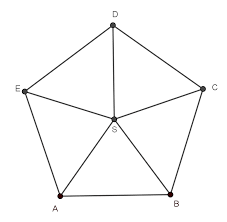

(Triangle's area formula from: https://mathbitsnotebook.com/Geometry/TrigApps/TAarea.html)

In [ ]:
def find_canada_latest_cases():
    canada_cases = spark.sql("SELECT Date,Sub_Region1 as Province1, \
     SUM(Confirmed) AS Confirmed_Cases,\
     SUM(Recovered) AS Recovered_Cases,\
     SUM(Deaths) AS Total_Deaths\
     FROM cases\
     WHERE Country_Region = 'Canada' and Date = '2020-04-19'\
     group by Date,Sub_Region1 \
     order by sum(Confirmed) DESC")
    return canada_cases
ca_cases = find_canada_latest_cases()
total_cases = ca_cases.groupBy().sum().collect()
confirmed = total_cases[0][0]
recovered = total_cases[0][1]
deaths = total_cases[0][2]
ca_cases = ca_cases.drop('Date')
ca_cases.show()

In [ ]:
confirmed

In [ ]:
canada_mobility_latest = canada_mobility_by_province_by_date.filter("Date='2020-04-11'").drop("Date")
canada_mobility_latest.show()
canada_mobility_agg = canada_mobility_latest.join(ca_cases,canada_mobility_latest.Province==ca_cases.Province1, how="left").drop("Province1").toPandas()

In [ ]:
data_columns = ['Retail_and_Recreation',
    'Grocery_and_Pharmacy',
    'Parks',
    'Transit_Stations',
    'Workplace',
    'Residential']

min_values = canada_mobility_agg[data_columns].min()
max_values = canada_mobility_agg[data_columns].max()
min_val = min_values.min()
max_val = max_values.max()
canada_mobility_agg = canada_mobility_agg.set_index('Province').rename_axis(None)
# incidence = {k: v / total_cases for k, v in cases_by_province.items()}
# canada_mobility_agg['rate'] = canada_mobility_agg.index.to_series().map(incidence)

In [ ]:
canada_mobility_agg.to_csv("canada_mobility.csv")

In [ ]:
ontario_data = canada_mobility_agg.loc['Ontario', data_columns[:-1]].tolist()
ontario_data
area = math.fsum(
    triangle_area(a, b, 360 / len(ontario_data), min_val)
    for a, b in zip(ontario_data, ontario_data[1:] + ontario_data[:1])
)
area

In [ ]:
import math
def triangle_area(a, b, angle, zero):
    return 0.5 * (a - zero) * (b - zero) * np.sin(np.deg2rad(angle))

for index, row in canada_mobility_agg.iterrows():
    lst = row[data_columns[:-1]].tolist()
    area = math.fsum(
        triangle_area(a, b, 360 / len(lst), min_val)
        for a, b in zip(lst, lst[1:] + lst[:1])
    )
    canada_mobility_agg.loc[index, 'area'] = area

In [ ]:
data_columns = ['Retail_and_Recreation',
    'Grocery_and_Pharmacy',
    'Parks',
    'Transit_Stations',
    'Workplace',
    'Residential']

min_values = canada_mobility_agg[data_columns].min()
max_values = canada_mobility_agg[data_columns].max()
min_val = min_values.min()
max_val = max_values.max()
ontario_data = canada_mobility_agg.loc['Ontario', data_columns[:-1]].tolist()
ontario_data
def triangle_area(a, b, angle, zero):
    return 0.5 * (a - zero) * (b - zero) * np.sin(np.deg2rad(angle))


In [ ]:
for index, row in canada_mobility_agg.iterrows():
    lst = row[data_columns[:-1]].tolist()
    area = sum(
        triangle_area(a, b, 360 / len(lst), min_val)
        for a, b in zip(lst, lst[1:] + lst[:1])
    )
    canada_mobility_agg.loc[index, 'area'] = area

In [ ]:
confirmed = 35632
canada_mobility_agg['Confirmed_Cases'].fillna(0)
canada_mobility_agg['rate'] = canada_mobility_agg['Confirmed_Cases']/confirmed
canada_mobility_agg.index.names = ['Province']

In [ ]:
province_codes = {
    'Canada': 'CA',
    'Alberta': 'AB',
    'British Columbia': 'BC',
    'Manitoba': 'MB',
    'New Brunswick': 'NB',
    'Newfoundland and Labrador': 'NL',
    'Northwest Territories': 'NT',
    'Nova Scotia': 'NS',
    'Nunavut': 'NU',
    'Ontario': 'ON',
    'Prince Edward Island': 'PE',
    'Quebec': 'QC',
    'Saskatchewan': 'SK',
    'Yukon': 'YT',
}
canada['province_code'] = canada.index.to_series().map(province_codes)
a = ['YT', 'NT', 'NU','PE']
canada = canada[~canada["province_code"].isin(a)]


In [ ]:
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
# linear regression
# regline = sm.OLS(canada.rate, sm.add_constant(canada.area.values)).fit().fittedvalues
mod = sm.OLS(canada.rate, sm.add_constant(canada.area.values))
regline = mod.fit().fittedvalues
res = mod.fit()
fig = px.scatter(
    canada, x="area", y="rate", color="province_code",
    labels={"area": "Circulation Indicator", "rate": "Incidence Rate"},
    text="province_code", size="Residential"
)

def add_trace_copy(trace):
    fig.add_traces(trace)
    new_trace = fig.data[-1]
    new_trace.update(textposition='top center', mode="text", showlegend=False)
    trace.update(mode="markers")
fig.for_each_trace(add_trace_copy)

# add linear regression line for whole sample
fig.add_traces(
    go.Scatter(
        x=canada.area,
        y=regline,
        mode='lines',
        marker_color='black',
        name='Trend all'
    )
)

fig.update_traces(textposition='middle center')

fig.show()

print(res.summary())